#Discretizing a Multifactor Price Model to a Lattice

In this example, a multifactor model, as it is common among commodity traders, will be reduced to a discrete lattice for later usage as input to an optimization problem. 
The example is based on the article "[Optimal gas storage valuation and futures trading under a high-dimensional price process](http://www.optimization-online.org/DB_FILE/2015/05/4913.pdf)" by Löhndorf and Wozabal (2015).

## The Multifactor Model
The multifactor model used here describes the dynamics of the forward curve of gas prices at the NYMEX Henry Hub as a driftless multivariate geometric Brownian motion (MGBM). 

Denote $F_t$ as the forward curve in $t$, i.e., the vector of forward prices, with $F_{tj}$ as the forward price in period $t=1,\dots,T$ with maturity in period $j=t,\dots,T$, where $T$ is the number of months in the planning period. Denote $dZ_{tj}$ as a standard Brownian motion increment related to a forward contract in $t$ with maturity in $j \geq t$ and $\sigma_j$ as the constant monthly volatility and $\rho_{jk}$ as the instantaneous correlation of increments $dZ_{tj}$ and $dZ_{tk}$. Then, the MGBM is defined by the stochastic differential equations,
$$
\frac{dF_{tj}}{F_{tj}} = \sigma_j d Z_{tj}, \ dZ_{tj} dZ_{tk} = \rho_{jk}, \  j=1,\dots,T.
$$

## Importing Model Parameters
The parameters are taken from the Operations Research article by Lai, Margot, and Secomandi (2015) and stored in three separate CSVs. The e-companion that contains the data can be found [here](http://pubsonline.informs.org/doi/suppl/10.1287/opre.1090.0768). The authors of the article calibrate four versions of the MGBM price process, each using the information available at the closing of NYMEX Henry Hub on 3/1/2006 (Spring), 6/1/2006 (Summer), 8/31/2006 (Fall), and 12/1/2006 (Winter). 

The initial state of the MGBM, $F_1$, is given by the spot price and the futures prices of the first 23 maturities on each of the four days and stored. Implied volatilities of the 23 futures prices are obatined from prices of NYMEX call options on natural gas futures. The correlation matrix is constructed from the historical correlation of the first 23 maturities of each trading day from 1/2/1997 to 12/14/2006.

In [1]:
season = 'Spring'
num_months = 24
# import the forward curve which also serves as initial value fo the MGBM
forwards_csv = pd.read_csv('assets/forwards.csv', index_col=0)
forward_curve = forwards_csv[season].values.tolist()[:num_months]
initial_values = forward_curve[1:num_months]
num_futures = len(initial_values)
# import the correlation matrix
correlation_csv = pd.read_csv('assets/correlation.csv', index_col=0)
correlation_matrix = correlation_csv.values.tolist()
# import the volatilities
volatility_csv = pd.read_csv('assets/volatility.csv', index_col=0)
volatilities = volatility_csv[season].mul(1./math.sqrt(12)).values.tolist()[:num_months]
# no drift
drift = [0.]*num_futures
# provide a name for each state variable
names = ['price_%d'%i for i in range(1,num_futures+1)]

## Lattice Generation
The lattice is generated by iteratively drawing simulated sample paths of the price process. We therefore must provide a simulation model of the MGBM which is provided by the PyQuasar class MGBM.

In [2]:
from pyquasar import *
mgbm = MGBM(names,initial_values,drift,volatilities,correlation_matrix)

A sample of simulated time series from the price process can be stored in a QuasarDataFrame for later output analysis.

In [3]:
sample_size = 1000
process_sample = mgbm.simulate(sample_size=sample_size, num_stages=num_months)
process_sample.set_time_index(start='2006-03',freq='MS')
process_sample[0:10].transpose()[0:5]

series           0                                                         \
stage   2006-03-01 2006-04-01 2006-05-01 2006-06-01 2006-07-01 2006-08-01   
price_1       6.73       6.13       5.79       6.38       6.52       5.64   
price_2       6.94       5.68       5.52       5.95       5.73       4.94   
price_3       7.12       5.62       5.48       5.63       5.26       4.80   
price_4       7.29       6.05       5.86       6.22       5.53       4.98   
price_5       7.42       6.32       6.05       6.66       5.72       4.98   

series                                               
stage   2006-09-01 2006-10-01 2006-11-01 2006-12-01  
price_1       7.94       7.50       6.98       5.57  
price_2       6.35       5.71       5.17       4.30  
price_3       6.25       5.54       4.91       4.12  
price_4       6.60       5.90       5.69       4.79  
price_5       6.63       6.16       5.87       5.16

To reduce the multifactor model to a discrete lattice, we can use the PyQuasar class Lattice. We use the same settings for the lattice as in the above mentioned article.

In [10]:
num_nodes = 50
lattice = Lattice(
    process = mgbm,
    num_stages = num_months,
    state_variables=names,
    num_nodes=num_nodes,
    sample_size=num_nodes * 10000,
    match_means= True,
    scenario_reduction_method ='CONDITIONAL_KMEANS'
)

In [11]:
lattice_sample = lattice.simulate(sample_size=sample_size, num_stages=num_months)
lattice_sample.set_time_index(start='2006-03',freq='MS')
lattice_sample[0:10].transpose()[0:5]

series           0                                                         \
stage   2006-03-01 2006-04-01 2006-05-01 2006-06-01 2006-07-01 2006-08-01   
price_1       6.73       5.96       5.04       5.69       5.20       4.45   
price_2       6.94       6.21       5.17       5.80       5.32       4.58   
price_3       7.12       6.42       5.26       5.85       5.39       4.64   
price_4       7.29       6.62       5.33       5.86       5.42       4.68   
price_5       7.42       6.75       5.30       5.79       5.37       4.62   

series                                               
stage   2006-09-01 2006-10-01 2006-11-01 2006-12-01  
price_1       4.21       4.22       4.05       3.65  
price_2       4.33       4.33       4.15       3.75  
price_3       4.38       4.38       4.20       3.80  
price_4       4.42       4.40       4.23       3.83  
price_5       4.36       4.32       4.14       3.75

## Simulation
To visually assess the quality of the lattice, we are going to compare the two samples drawn from the MGBM and the lattice. This is important to gain confidence into the quality of the scenarios which will be used later for optimization.

### Comparison of realized sample paths
First let's compare the time series that are generated for one of the 23 state variables to see whether the time series look similar. From the two plots we can see that the lattice yield scenarios that cover the outcome space of the multifactor model in regions of high probability density particularily well, but also gives a good representation of the tails.

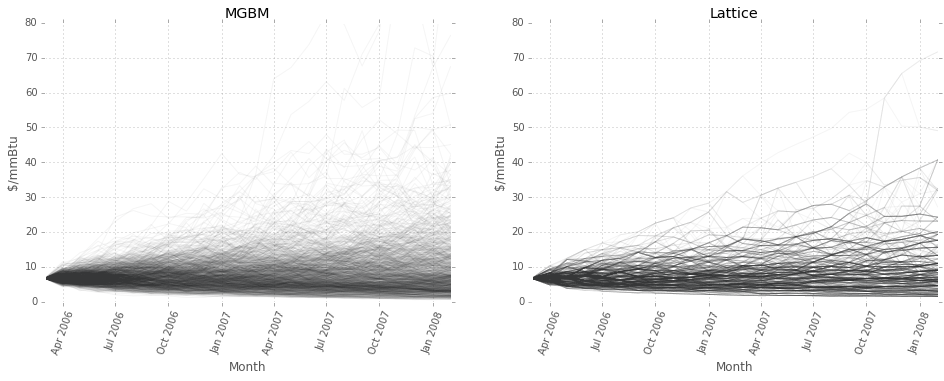

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.set_ylim(0,80)
ax2.set_ylim(0,80)
process_sample.price_1.spaghetti(ax=ax1, xlabel='Month', ylabel='$/mmBtu', title='MGBM', alpha=0.05)
lattice_sample.price_1.spaghetti(ax=ax2, xlabel='Month', ylabel='$/mmBtu', title='Lattice', alpha=0.05)

### PCA of the unconditional (cross-sectional) distribution
The time series plots only show a single dimension of the process. To gain insight into the quality of the scenarios in 23-dimensional space, we can resort to principal components analysis (PCA) of the joint unconditional distribution of all future prices at one stage and then create scatter plots of the first two principal components. 

In [13]:
from sklearn.decomposition import PCA
stage = '2008-02'
process_sample_stage = process_sample.groupby_stage.get_group(stage)
lattice_sample_stage = lattice_sample.groupby_stage.get_group(stage)
pca = PCA().fit(process_sample_stage)
process_components = pca.transform(process_sample_stage)
var_exp = [sum(pca.explained_variance_ratio_[0:i]) for i in range(num_futures+1)]
lattice_components = pca.transform(lattice_sample_stage)

The plots below show the first two components of realizations from the MGBM as black dots and realizations from the lattice as red squares. We can see that the lattice spreads the scenarios well along the first two components with more emphasis on the first component, which is expected. The first two components already explain the largest part of the variance which can be seen from the right panel. 

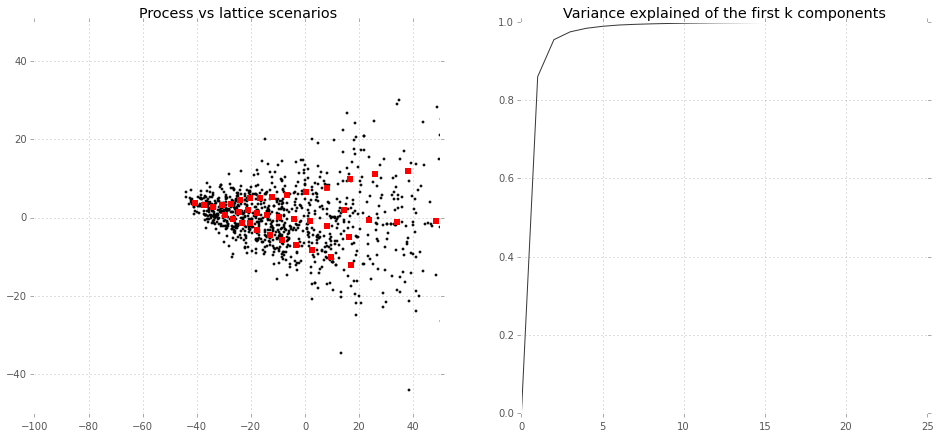

In [14]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,7))
ax1.scatter(process_components[:,0],process_components[:,1],color='black',marker='.')
ax1.scatter(lattice_components[:,0],lattice_components[:,1],color='red',marker=',',s=25)
ax1.set_ylim(-50,50)
ax1.set_xlim(-100,50)
ax1.set_title('Process vs lattice scenarios')
ax2.plot(range(0,num_futures+1),var_exp)
ax2.set_ylim(0,1)
ax2.set_title('Variance explained of the first k components')
plt.show()

## Export the Lattice
To use the lattice for stochastic optimization, we can store as CSV.

In [15]:
lattice.to_csv('MGBM_%d-node-lattice_%s'%(num_nodes,season))